Laura Nembrini Matr. 819059 \
Gabriele Strano Matr. 866563 \
Davide Mancino Matr. 847700


# Importo pacchetti necessari

In [1]:
! pip install keras

In [38]:
! pip install cv2

  Could not find a version that satisfies the requirement cv2 (from versions: )
No matching distribution found for cv2


In [2]:
import cv2 as cv
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras
from keras.utils import np_utils

from keras.models import Sequential,Model
from keras.layers import ZeroPadding2D,Conv2D,MaxPooling2D
from keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization,Input,AveragePooling2D
from keras.preprocessing.image import load_img,img_to_array
from keras.applications.imagenet_utils import preprocess_input
import keras.backend as K


from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from pickle import dump, load

C:\Users\LAURA\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


# FACE DETECTION

La funzione detection_face ritaglia solamente il volto partendo dalle immagini originali. Per fare questo è stato usato un face detector che permette di individuare automaticamente il volto della persona. Dopo averla individuata, viene tagliata e salvata in una apposita cartella. Non sempre però il face detector riesce ad individuare correttamente il volto quindi, per rimediare a questo problema si è deciso di fare un cropping manuale per quelle immagini per cui il face detector non è stato in grado di identificare il volto. 

In [4]:
def detection_face(directory1, directory2,size = (224, 224)):
    # Load model to detect frontal faces
    face_detector = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml') 
    # variable for count errors
    f = 1
    err_noimg = 0
    
    for filename in os.listdir(directory1):
        # check for load only jpg and tiff images extension
        if filename.endswith(".jpg"):
             # load image          
            img = cv.imread(os.path.join(directory1, filename))
            # conversion of image, this passage is necessary to pass images on face detector
            img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
            faces = face_detector.detectMultiScale(img_gray)
            if len(faces) == 1:
                for (x, y, w, h) in faces:
                    # cut images on bases of segmentation of face detector
                    roi_color = img[y:y+h, x:x+w]
                    # resize of image
                    re_img = cv.resize(roi_color, size)
                    cv.imwrite(os.path.join(directory2, filename), re_img)
                    f += 1
            else:
                err_noimg += 1 
                img = cv.imread(os.path.join(directory1,filename,))
                w = round(img.shape[1]/2)
                h = round(img.shape[0]/2)
                face = img[h-100:h+100, w-100:w+100]
                img = cv.resize(img, (224,224), interpolation = cv.INTER_AREA)
                cv.imwrite(os.path.join(directory2, filename), face)
                
                    
    
    # output          
    print('Created {}/{} images cropped'.format(f-1, f+err_noimg-1))

In [5]:
directory2=("C:/Users/LAURA/Desktop/DSIMPROJECT/CROP/LAURA")
from_directory=("C:/Users/LAURA/Desktop/DSIMPROJECT/LAURA")
detection_face(directory1=from_directory, directory2=directory2)

Created 22/30 images cropped


In [6]:
directory2=("C:/Users/LAURA/Desktop/DSIMPROJECT/CROP/GABRIELE")
from_directory=("C:/Users/LAURA/Desktop/DSIMPROJECT/GABRIELE")
detection_face(directory1=from_directory, directory2=directory2)

Created 26/30 images cropped


In [7]:
directory2=("C:/Users/LAURA/Desktop/DSIMPROJECT/CROP/DAVIDE")
from_directory=("C:/Users/LAURA/Desktop/DSIMPROJECT/DAVIDE")
detection_face(directory1=from_directory, directory2=directory2)

Created 21/30 images cropped


# CARICAMENTO IMMAGINI CON RELATIVE LABELS
Attraverso la funzione face_loader vengono prese le immagini ritagliate e viene effettuato un pre-processing utile per il successivo training del modello. 

In [8]:
def face_loader(path):
    faces = []
    labels = []
    for person in os.listdir(path):
        for photo in os.listdir(path + '/' + person):
            img_path=path + '/' + person + '/' + photo
            image=load_img(img_path, target_size=(224,224))
            image=img_to_array(image)
            image=preprocess_input(image)
            faces.append(image)
            labels.append(person)
            

    return faces, labels


In [9]:
percorso="C:/Users/LAURA/Desktop/DSIMPROJECT/CROP"
faces, labels = face_loader(percorso)

In [11]:
#labels in one-hot encoding
encoder = LabelEncoder()
labels_enc = encoder.fit_transform(labels)
y = np_utils.to_categorical(labels_enc, 3)


In [13]:
dump(encoder, open('labelenc.pkl', 'wb'))

In [14]:
x_train, x_test, y_train, y_test = train_test_split(faces, y, test_size=0.3, random_state=111)

In [15]:
x_train = np.array(x_train)
x_test = np.array(x_test)

# CARICAMENTO RETE PRE ADDESTRATA (MOBILENETV2)

In [16]:
# Load a pre-trained neural network to use for transfer learning
base_net = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    weights='imagenet',
    include_top=False,
    pooling='avg'
)

In [17]:
#esploro architettura
len(base_net.layers) 

155

In [18]:
base_net.summary() 

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

# FINE TUNING: adattamento rete 
Una volta importato il modello, sono stati aggiunti 2 blocchi composti da 2 hidden layer di tipo fully-connected con 512 neuroni per il primo blocco e 256 per il secobdo blocco, entrambi con funzione di attivazione reLU.
Infine è stato aggiunto un layer di output con 3 neuroni e funzione di attivazione softmax. 

Come funzione di loss è stata usata la 'categorical_crossentropy' e come funzione di optimizer Adam.

E' stata inoltre effettuata la **data augmentation**.

In [19]:
#Ora imposteremo tutti i livelli pre-addestrati su False in modo che non possano essere addestrati di nuovo.
for layer in base_net.layers:
    layer.trainable=False

In [20]:
inputs = keras.Input(shape=(224,224,3))
x = inputs
### Data augmentation 
x = keras.layers.RandomFlip("horizontal")(x)
x = keras.layers.RandomRotation(0.2, fill_mode="nearest")(x)
x = keras.layers.RandomZoom(0.6)(x)
x = keras.layers.RandomContrast(0.8)(x)
###
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base_net(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(3, activation='softmax')(x)
outputs = x

In [21]:
net = keras.Model(inputs=inputs, outputs=outputs)

In [22]:
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0     

In [23]:
net.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# TRAINING DEL MODELLO E RISULTATI

Per il training del modello sono stati usati i seguenti parametri:
1. numero di epoche: 20
2. batch size: 4

Infine i modelli sono stati salvati per la creazione della demo

In [25]:
# Train the neural network
history = net.fit(x_train, y_train, batch_size=4, epochs=20, validation_split=0.3) 

Epoch 1/20
11/11 [==============================] - 14s 543ms/step - loss: 1.3910 - accuracy: 0.5682 - val_loss: 0.5870 - val_accuracy: 0.7368
Epoch 2/20
11/11 [==============================] - 3s 300ms/step - loss: 0.4652 - accuracy: 0.8409 - val_loss: 0.0621 - val_accuracy: 0.9474
Epoch 3/20
11/11 [==============================] - 3s 314ms/step - loss: 0.1728 - accuracy: 0.9545 - val_loss: 0.0772 - val_accuracy: 0.9474
Epoch 4/20
11/11 [==============================] - 3s 299ms/step - loss: 0.1038 - accuracy: 0.9545 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 5/20
11/11 [==============================] - 3s 307ms/step - loss: 0.1301 - accuracy: 0.9545 - val_loss: 0.0208 - val_accuracy: 1.0000
Epoch 6/20
11/11 [==============================] - 3s 315ms/step - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.0271 - val_accuracy: 1.0000
Epoch 7/20
11/11 [==============================] - 3s 309ms/step - loss: 0.3176 - accuracy: 0.9545 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch

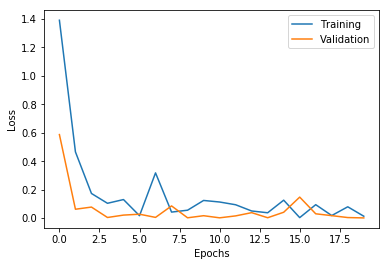

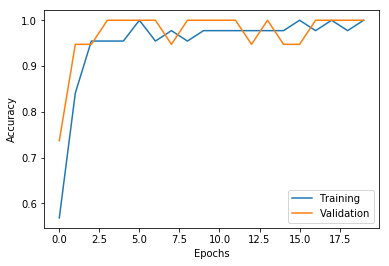

In [26]:
# Plot training history
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(history)

In [27]:
#valutazione
pred = net.predict(x_test)
pred = np.argmax(pred, axis=1)
print(classification_report(encoder.inverse_transform(np.argmax(y_test, axis=1)), encoder.inverse_transform(pred)))

              precision    recall  f1-score   support

      DAVIDE       1.00      1.00      1.00         9
    GABRIELE       1.00      1.00      1.00         9
       LAURA       1.00      1.00      1.00         9

   micro avg       1.00      1.00      1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



In [28]:
#save the net
net.save('facerec.h5')

C:\Users\LAURA\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# RICONOSCIMENTO REAL-TIME

In [29]:
encoder = load(open('labelenc.pkl', 'rb'))

In [30]:
net = keras.models.load_model("facerec.h5")

In [31]:
def detect_faces(image):
    # Load model to detect frontal faces
    face_detector = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray, minNeighbors=4, scaleFactor=1.15, minSize=(100,100))
    img_bbx = image
    for (x,y,w,h) in faces:
        # Recognize faces
        face = image[y:y + h, x:x + w]
        resized_face = cv.resize(face, dsize=(224, 224), interpolation=cv.INTER_CUBIC)
        pred = net.predict(np.expand_dims(resized_face, axis=0))
        index = np.argmax(pred, axis=1)
        person = encoder.inverse_transform(index)[0]
        prob = round(pred[0][index[0]]*100, 1)
        color=(0,255,0)
        # If there is not enough certainty
        if prob < 70:
            person = 'Unknown'
            color=(0,0,255)
        # Draw rectangles and put labels with confidence
        cv.rectangle(img_bbx,(x,y),(x+w,y+h),color,2)
        cv.putText(img_bbx, person + ' ' + str(prob) + '%', (x+5,y-5), cv.FONT_HERSHEY_PLAIN, 1, (255,255,255), 2)
    return img_bbx

In [44]:
# Start real-time face recognition
cap = cv.VideoCapture(0)
while(True):
    # Capture new frame
    r, frame = cap.read()
    # Process its content
    frame = detect_faces(frame)
    # Visualize (external window)
    cv.imshow('Video', frame)
    # Interrupt when Q key is pressed
    if cv.waitKey(20) & 0xFF == ord('q'):
        break
cap.release()
cv.destroyAllWindows()